In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as sm
import seaborn as sns
import tensorflow.compat.v1 as tf

In [26]:
data = pd.read_csv('clustering.csv')
data = data[['bruises','odor','stalk-shape','veil-type','spore-print-color']]
data


,bruises,odor,stalk-shape,veil-type,spore-print-color
0,1,p,e,p,2
1,1,a,e,p,3
2,1,l,e,p,3
3,1,p,e,p,2
4,0,n,t,p,3
...,...,...,...,...,...
495,1,a,e,p,3
496,0,n,t,p,3
497,1,a,e,p,3
498,1,a,e,p,3


In [27]:
for idx, i in enumerate(data['odor']):
    if i == "a":
        data['odor'][idx] = 1
    elif i == "l":
        data['odor'][idx] = 2
    elif i == "c":
        data['odor'][idx] = 3
    elif i == "y":
        data['odor'][idx] = 4
    elif i == "f":
        data['odor'][idx] = 5
    elif i == "m":
        data['odor'][idx] = 6
    elif i == "n":
        data['odor'][idx] = 7
    elif i == "p":
        data['odor'][idx] = 8
    elif i == "s":
        data['odor'][idx] = 9

for idx, i in enumerate(data['stalk-shape']):
    if i == "e":
        data['stalk-shape'][idx] = 1
    elif i == "t":
        data['stalk-shape'][idx] = 2

for idx, i in enumerate(data['veil-type']):
    if i == "p":
        data['veil-type'][idx] = 1
    elif i == "u":
        data['veil-type'][idx] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/d

In [28]:
data

,bruises,odor,stalk-shape,veil-type,spore-print-color
0,1,8,1,1,2
1,1,1,1,1,3
2,1,2,1,1,3
3,1,8,1,1,2
4,0,7,2,1,3
...,...,...,...,...,...
495,1,1,1,1,3
496,0,7,2,1,3
497,1,1,1,1,3
498,1,1,1,1,3


In [29]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [30]:
data

array([[1.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.25      ],
       [1.        , 0.14285714, 0.        , 0.        , 0.25      ],
       ...,
       [1.        , 0.        , 0.        , 0.        , 0.25      ],
       [1.        , 0.        , 0.        , 0.        , 0.25      ],
       [1.        , 0.14285714, 0.        , 0.        , 0.        ]])

In [31]:
pca = PCA(n_components=3)
pca = pca.fit(data)
dataset = pca.transform(data)

In [32]:
dataset

array([[ 0.25083049, -0.45227518,  0.5330749 ],
       [-0.36932484,  0.02732872, -0.08035104],
       [-0.28016679, -0.03061502,  0.01492071],
       ...,
       [-0.36932484,  0.02732872, -0.08035104],
       [-0.36932484,  0.02732872, -0.08035104],
       [-0.28411783, -0.10461277, -0.03855562]])

In [33]:
tf.compat.v1.disable_eager_execution()

In [34]:
class SOM:

    def __init__(self, height, width, input_dimension):
        self.height = height
        self.width = width
        self.input_dimension = input_dimension
        self.location = [tf.to_float([y, x])
                         for y in range(height) for x in range(width)]

        self.weight = tf.Variable(tf.random_normal(
            [width*height, input_dimension]))
            
        self.input = tf.placeholder(tf.float32, [input_dimension])

        best_matching_unit = self.get_bmu()

        self.updated_weight, self.rate_stacked = self.update_neighbour(
            best_matching_unit)

    def get_bmu(self):
        square_difference = tf.square(self.input - self.weight)
        distance = tf.sqrt(tf.reduce_mean(square_difference, axis=1))

        bmu_index = tf.argmin(distance)
        bmu_location = tf.to_float(
            [tf.div(bmu_index, self.width), tf.mod(bmu_index, self.width)])

        return bmu_location

    def update_neighbour(self, bmu):
        learning_rate = 0.6

        sigma = tf.to_float(tf.maximum(self.width, self.height)/2)

        square_difference = tf.square(self.location - bmu)
        distance = tf.sqrt(tf.reduce_mean(square_difference, axis=1))

        neighbour_strength = tf.exp(
            tf.div(tf.negative(tf.square(distance)), 2 * tf.square(sigma)))

        rate = neighbour_strength * learning_rate
        total_node = self.width * self.height
        rate_stacked = tf.stack([tf.tile(tf.slice(rate, [i], [1]), [
                                self.input_dimension]) for i in range(total_node)])

        input_weight_difference = tf.subtract(self.input, self.weight)

        weight_difference = tf.multiply(rate_stacked, input_weight_difference)

        weight_new = tf.add(self.weight, weight_difference)

        return tf.assign(self.weight, weight_new), rate_stacked

    def train(self, dataset, num_of_epoch):
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)

            for i in range(num_of_epoch):
                for data in dataset:
                    sess.run(self.updated_weight, feed_dict={
                        self.input: data
                    })

            cluster = [[] for i in range(self.height)]
            location = sess.run(self.location)
            weight = sess.run(self.weight)

            for i, loc in enumerate(location):
                print(i, loc[0])
                cluster[int(loc[0])].append(weight[i])

            self.cluster = cluster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 2.0
13 2.0
14 2.0
15 2.0
16 2.0
17 2.0
18 3.0
19 3.0
20 3.0
21 3.0
22 3.0
23 3.0
24 4.0
25 4.0
26 4.0
27 4.0
28 4.0
29 4.0
30 5.0
31 5.0
32 5.0
33 5.0
34 5.0
35 5.0


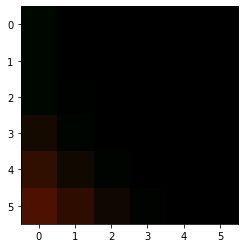

In [ ]:
height = 6
width = 6

input_dimension = 3
som = SOM(height, width, input_dimension)
som.train(dataset, 2500)

plt.imshow(som.cluster)
plt.show()